In [1]:
# Question: Advanced Data Cleaning with Multiple Issues
# Objective: Handle multiple issues in one dataset, including missing values, duplicates, and outliers.
# Description: Given a dataset with various data quality issues, employ multiple data cleaning techniques.
import pandas as pd
import numpy as np
from scipy import stats
def clean_data(df):
    df = df.copy()
    df = df.drop_duplicates()
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)
    numeric_cols = df.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df[col] = np.where(df[col] > upper_bound, upper_bound, 
                          np.where(df[col] < lower_bound, lower_bound, df[col]))
    df = df.reset_index(drop=True)
    return df
data = {
    'ID': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1],
    'Age': [25, 32, 45, 28, np.nan, 25, 52, 38, 29, 150, 25],
    'Income': [50000, 75000, 120000, 68000, 92000, 50000, 110000, 85000, np.nan, 2500000, 50000],
    'Category': ['A', 'B', 'C', 'D', 'E', 'A', 'B', 'C', np.nan, 'F', 'A']
}
df = pd.DataFrame(data)
cleaned_df = clean_data(df)
print("Original Data:")
print(df)
print("\nCleaned Data:")
print(cleaned_df)



Original Data:
    ID    Age     Income Category
0    1   25.0    50000.0        A
1    2   32.0    75000.0        B
2    3   45.0   120000.0        C
3    4   28.0    68000.0        D
4    5    NaN    92000.0        E
5    6   25.0    50000.0        A
6    7   52.0   110000.0        B
7    8   38.0    85000.0        C
8    9   29.0        NaN      NaN
9   10  150.0  2500000.0        F
10   1   25.0    50000.0        A

Cleaned Data:
     ID    Age    Income Category
0   1.0  25.00   50000.0        A
1   2.0  32.00   75000.0        B
2   3.0  45.00  120000.0        C
3   4.0  28.00   68000.0        D
4   5.0  32.00   92000.0        E
5   6.0  25.00   50000.0        A
6   7.0  52.00  110000.0        B
7   8.0  38.00   85000.0        C
8   9.0  29.00   85000.0        A
9  10.0  65.75  159125.0        F


Original Skewness:
Revenue           3.151799
PageViews         3.152011
ConversionRate    3.140483
dtype: float64

Transformed Skewness:
Revenue           2.193224
PageViews        -0.778144
ConversionRate    2.245959
dtype: float64

Skewness Improvement Analysis:
                original_skew  transformed_skew  improvement
Revenue              2.657830          1.849489     0.808341
PageViews            2.658009         -0.656188     3.314198
ConversionRate       2.648288          1.893959     0.754328


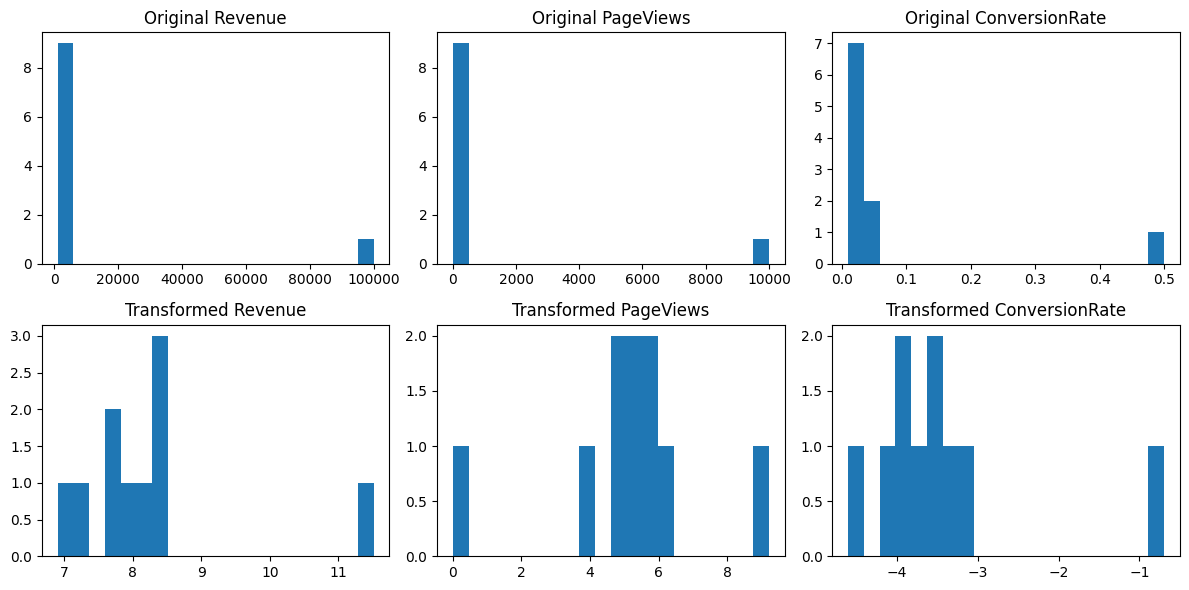

In [2]:
# Question: Data Transformation Techniques
# Objective: Transform skewed data using log transformation.
# Description: Perform a log transformation to handle skewness in a dataset, which is particularly useful for
# certain machine learning models.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
def log_transform(df, columns):
    df = df.copy()
    for col in columns:
        if df[col].min() <= 0:
            df[col] = np.log1p(df[col])
        else:
            df[col] = np.log(df[col])
    return df
def analyze_skewness(df, columns):
    results = {}
    for col in columns:
        original_skew = stats.skew(df[col])
        transformed = np.log1p(df[col]) if df[col].min() <= 0 else np.log(df[col])
        transformed_skew = stats.skew(transformed)
        results[col] = {
            'original_skew': original_skew,
            'transformed_skew': transformed_skew,
            'improvement': original_skew - transformed_skew
        }
    return pd.DataFrame(results).T
data = {
    'Revenue': [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 100000],
    'PageViews': [0, 50, 100, 150, 200, 250, 300, 350, 400, 10000],
    'ConversionRate': [0.01, 0.02, 0.015, 0.03, 0.025, 0.02, 0.035, 0.04, 0.03, 0.5]
}
df = pd.DataFrame(data)
numeric_cols = ['Revenue', 'PageViews', 'ConversionRate']
print("Original Skewness:")
print(df[numeric_cols].skew())
transformed_df = log_transform(df, numeric_cols)
print("\nTransformed Skewness:")
print(transformed_df[numeric_cols].skew())
skewness_analysis = analyze_skewness(df, numeric_cols)
print("\nSkewness Improvement Analysis:")
print(skewness_analysis)
plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    plt.hist(df[col], bins=20)
    plt.title(f'Original {col}')
    plt.subplot(2, 3, i+3)
    plt.hist(transformed_df[col], bins=20)
    plt.title(f'Transformed {col}')
plt.tight_layout()
plt.show()

Original Features:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'PRICE']

Engineered Features:
{'OLD_HOUSE', 'ROOM_RATIO', 'HIGH_INCOME', 'ROOM_INCOME_INTERACTION', 'LAT_LONG_INTERACTION', 'POP_INCOME_INTERACTION', 'BEDRM_RATIO'}

Original Features MSE: 0.2554
Engineered Features MSE: 0.2593
Improvement: -1.52%


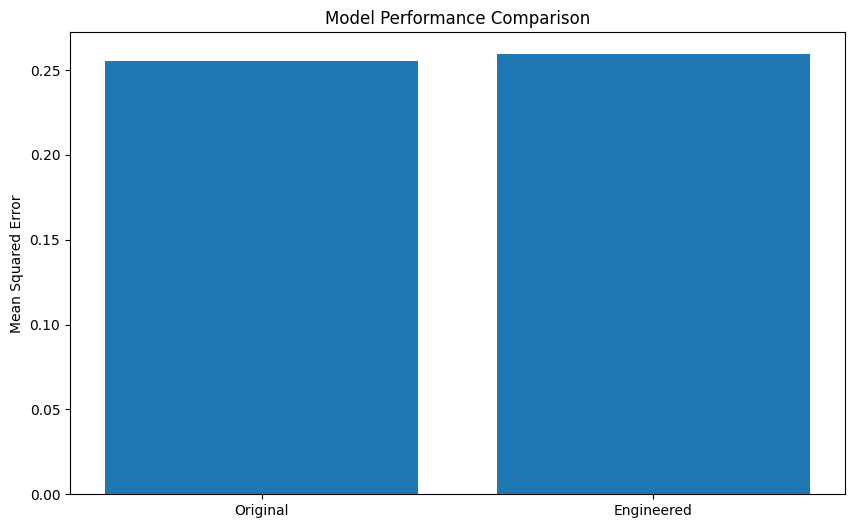

In [3]:
# Question: Feature Engineering by Creating New Features
# Objective: Create a new feature based on existing features to add predictive power.
# Description: Generate additional features from existing data to potentially improve the performance of
# prediction models.

import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
california = fetch_california_housing()
df = pd.DataFrame(california.data, columns=california.feature_names)
df['PRICE'] = california.target
def create_features(df):
    df = df.copy()
    df['ROOM_RATIO'] = df['AveRooms'] / df['HouseAge']
    df['BEDRM_RATIO'] = df['AveBedrms'] / (df['AveRooms'] + 1e-6)
    df['POP_INCOME_INTERACTION'] = df['Population'] * df['MedInc']
    df['LAT_LONG_INTERACTION'] = df['Latitude'] * df['Longitude']
    df['ROOM_INCOME_INTERACTION'] = df['AveRooms'] * df['MedInc']
    df['HIGH_INCOME'] = (df['MedInc'] > df['MedInc'].median()).astype(int)
    df['OLD_HOUSE'] = (df['HouseAge'] > df['HouseAge'].median()).astype(int)
    return df
engineered_df = create_features(df)

print("Original Features:")
print(df.columns.tolist())
print("\nEngineered Features:")
print(set(engineered_df.columns) - set(df.columns))

X_orig = df.drop('PRICE', axis=1)
X_eng = engineered_df.drop('PRICE', axis=1)
y = df['PRICE']

X_train_orig, X_test_orig, y_train, y_test = train_test_split(X_orig, y, test_size=0.2, random_state=42)
X_train_eng, X_test_eng, _, _ = train_test_split(X_eng, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train_orig, y_train)
orig_score = mean_squared_error(y_test, model.predict(X_test_orig))

model.fit(X_train_eng, y_train)
eng_score = mean_squared_error(y_test, model.predict(X_test_eng))

print(f"\nOriginal Features MSE: {orig_score:.4f}")
print(f"Engineered Features MSE: {eng_score:.4f}")
print(f"Improvement: {(orig_score - eng_score)/orig_score*100:.2f}%")

plt.figure(figsize=(10, 6))
plt.bar(['Original', 'Engineered'], [orig_score, eng_score])
plt.title('Model Performance Comparison')
plt.ylabel('Mean Squared Error')
plt.show()


Original Data Summary:
               Age         Income     Spending
count  1000.000000    1000.000000  1000.000000
mean     43.815198   64230.407718  1122.465462
std      21.008604   67950.756653  1070.754110
min      -8.619010   -7765.424104  -735.714946
25%      30.995165   37014.359769   654.310269
50%      41.194318   51536.164866  1008.174565
75%      51.524385   65567.807963  1356.498619
max     119.000000  488565.000000  9979.000000

Outliers Detected:
Age         37
Income      36
Spending    20
dtype: int64

Outliers Information:
Age: 37 outliers (3.70%)
Income: 36 outliers (3.60%)
Spending: 20 outliers (2.00%)

Processed Data Summary (Capped):
               Age         Income     Spending
count  1000.000000    1000.000000  1000.000000
mean     43.582315   60393.919114  1056.307018
std      20.248568   49653.177248   670.898748
min      -8.619010   -7765.424104  -735.714946
25%      30.995165   37014.359769   654.310269
50%      41.194318   51536.164866  1008.174565
75%    

/tmp/ipykernel_13840/3165362400.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[col], df_capped[col]], labels=['Original', 'Processed'])
/tmp/ipykernel_13840/3165362400.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[col], df_capped[col]], labels=['Original', 'Processed'])
/tmp/ipykernel_13840/3165362400.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[col], df_capped[col]], labels=['Original', 'Processed'])


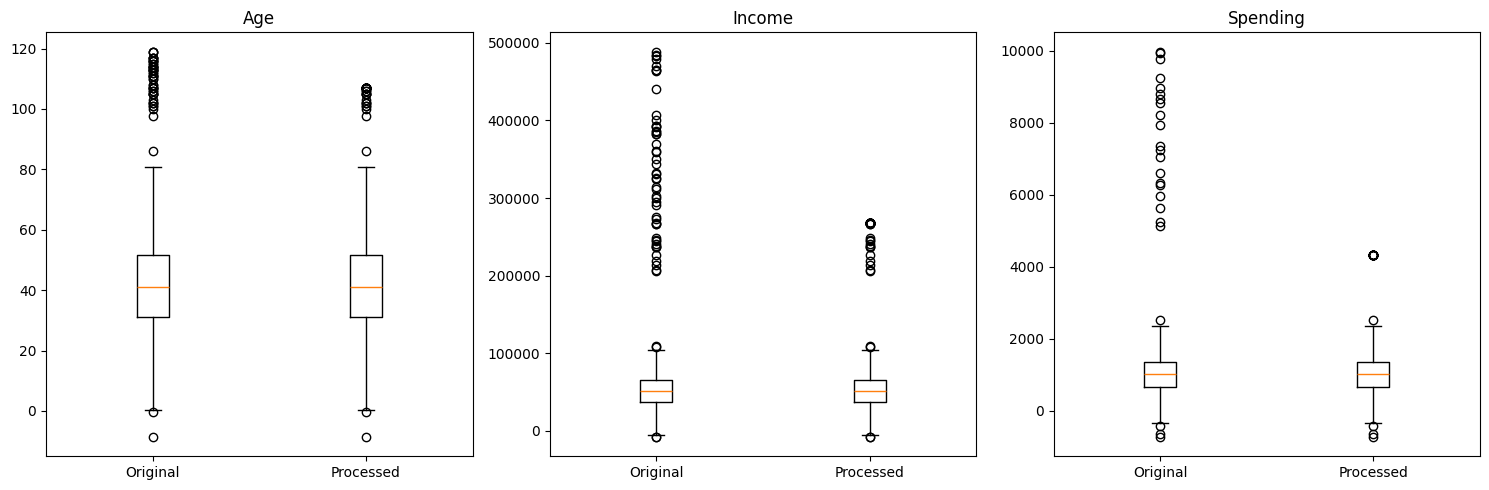

In [4]:
# Question: Handling Complex Outliers with Z-Scores
# Objective: Detect and handle outliers using Z-score method.
# Description: Use the Z-score method to identify outliers which significantly differ from the rest of the data points.

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
def detect_outliers_zscore(df, columns, threshold=3):
    df = df.copy()
    outliers_mask = pd.DataFrame(index=df.index)
    for col in columns:
        z_scores = np.abs(stats.zscore(df[col]))
        outliers_mask[col] = z_scores > threshold
    return outliers_mask
def handle_outliers(df, columns, method='cap', threshold=3):
    df = df.copy()
    outliers_info = {}
    for col in columns:
        z_scores = np.abs(stats.zscore(df[col]))
        outliers = z_scores > threshold
        outliers_info[col] = {
            'count': sum(outliers),
            'percentage': sum(outliers)/len(df)*100
        }
        if method == 'cap':
            upper_bound = df[col].mean() + threshold * df[col].std()
            lower_bound = df[col].mean() - threshold * df[col].std()
            df[col] = np.where(df[col] > upper_bound, upper_bound,
                              np.where(df[col] < lower_bound, lower_bound, df[col]))
        elif method == 'remove':
            df = df[z_scores <= threshold]
    
    return df, outliers_info
np.random.seed(42)
data = {
    'Age': np.concatenate([np.random.normal(40, 15, 950), np.random.randint(100, 120, 50)]),
    'Income': np.concatenate([np.random.normal(50000, 20000, 950), np.random.randint(200000, 500000, 50)]),
    'Spending': np.concatenate([np.random.normal(1000, 500, 980), np.random.randint(5000, 10000, 20)])
}
df = pd.DataFrame(data)
numeric_cols = ['Age', 'Income', 'Spending']
print("Original Data Summary:")
print(df.describe())
outliers_mask = detect_outliers_zscore(df, numeric_cols)
print("\nOutliers Detected:")
print(outliers_mask.sum())
df_capped, outliers_info = handle_outliers(df, numeric_cols, method='cap')
print("\nOutliers Information:")
for col, info in outliers_info.items():
    print(f"{col}: {info['count']} outliers ({info['percentage']:.2f}%)")
print("\nProcessed Data Summary (Capped):")
print(df_capped.describe())
plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 3, i)
    plt.boxplot([df[col], df_capped[col]], labels=['Original', 'Processed'])
    plt.title(col)
plt.tight_layout()
plt.show()


Original Data with Missing Values:
Age         18
Income      10
Spending    24
dtype: int64

After KNN Imputation:
Age         0
Income      0
Spending    0
dtype: int64


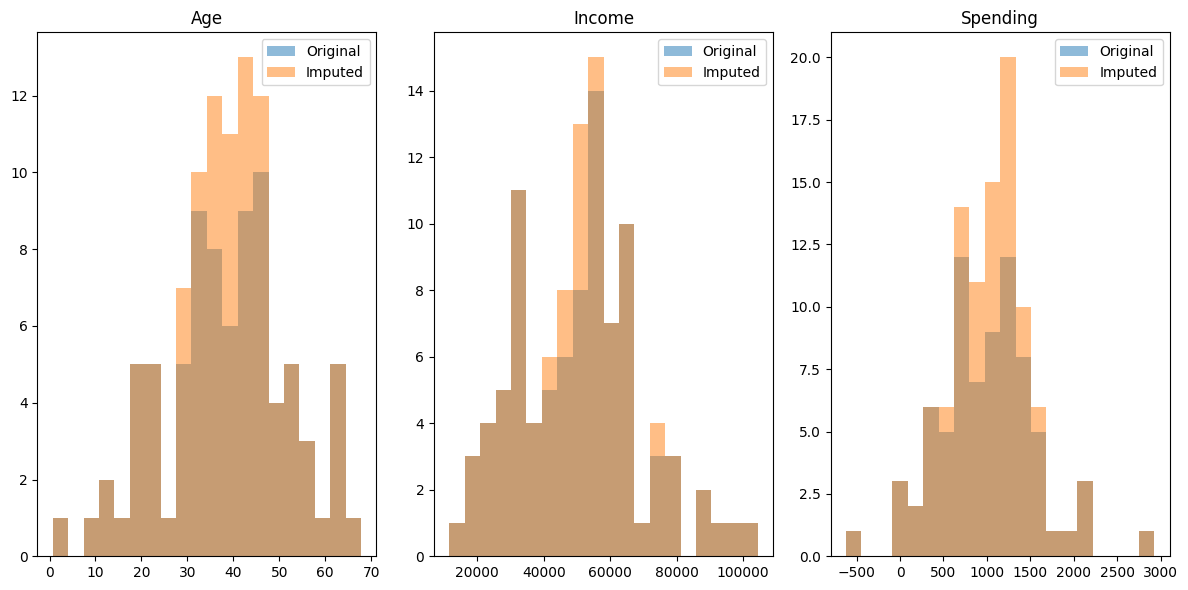


Statistical Comparison:
          Original Mean  Imputed Mean  Original Std   Imputed Std
Age           38.388412     38.471605     13.790851     12.614577
Income     50548.466175  50750.175373  19106.660570  18332.631367
Spending     995.101155   1019.459747    563.575221    506.589619


In [5]:
# Question: Data Imputation with K-Nearest Neighbors (KNN)
# Objective: Impute missing numerical values using the KNN method.
# Description: Use the K-nearest neighbors algorithm to fill in missing values, which considers the values of
# nearest neighbors for imputation.

import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
def knn_imputation(df, n_neighbors=5):
    numeric_cols = df.select_dtypes(include=np.number).columns
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[numeric_cols])
    
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_data = imputer.fit_transform(scaled_data)
    
    df_imputed = df.copy()
    df_imputed[numeric_cols] = scaler.inverse_transform(imputed_data)
    return df_imputed

np.random.seed(42)
data = {
    'Age': np.random.normal(40, 15, 100),
    'Income': np.random.normal(50000, 20000, 100),
    'Spending': np.random.normal(1000, 500, 100)
}
df = pd.DataFrame(data)
missing_mask = np.random.random(df.shape) < 0.15
df[missing_mask] = np.nan

print("Original Data with Missing Values:")
print(df.isnull().sum())

df_imputed = knn_imputation(df)

print("\nAfter KNN Imputation:")
print(df_imputed.isnull().sum())

plt.figure(figsize=(12, 6))
for i, col in enumerate(df.columns, 1):
    plt.subplot(1, 3, i)
    plt.hist(df[col], alpha=0.5, label='Original', bins=20)
    plt.hist(df_imputed[col], alpha=0.5, label='Imputed', bins=20)
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()

comparison = pd.DataFrame({
    'Original Mean': df.mean(),
    'Imputed Mean': df_imputed.mean(),
    'Original Std': df.std(),
    'Imputed Std': df_imputed.std()
})
print("\nStatistical Comparison:")
print(comparison)
